# Practical Work 6 - Recurrent Neural Network

## Introduction

Main goal: build a simple RNN for timeseries prediction.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from tensorflow.keras.optimizers import RMSprop


import warnings
warnings.filterwarnings("ignore")

# Data
[Data](https://www.kaggle.com/selfishgene/historical-hourly-weather-data) are weather related measures collected between 2012 et 2017 in 36 towns (1 measure per hour)

Choose a data set to process and set the corresponding variables (you can choose multiple ones, but the training time will be 
longer)

In [3]:
ts = "Temperature"
data = pd.read_csv("/content/drive/MyDrive/data/temperature.csv")

town='Montreal'
temp = data[['datetime',town]]


## Data preprocessing
some data is missing: interpolation to fill the missing values

In [4]:
print(temp.isna().sum()[town],"missing data out of",temp.shape[0])
temp.interpolate(inplace=True)
temp.dropna(inplace=True)


3 missing data out of 45253


## Training set
we extract the first `nb_samples` points for the training set. The rest of the data will serve as a test set, to assess the prediction of the model.


In [5]:
# Feel free to change this value to see the impact
nb_samples = 5000

temp_train = np.array(temp[town][:nb_samples]).ravel()
temp_test = np.array(temp[town][nb_samples:]).ravel()

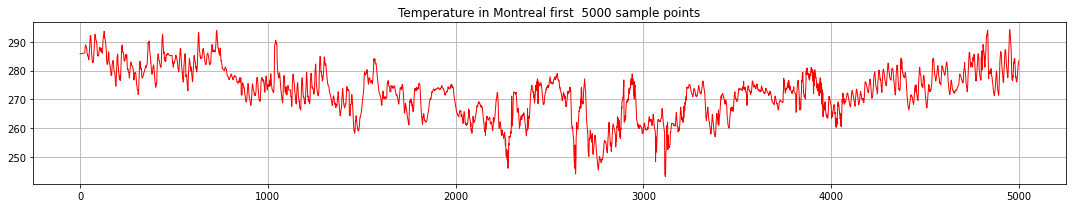

In [6]:
plt.figure(figsize=(15,3))

plt.title(ts +" in {0:s} first  {1:d} sample points".format(town,nb_samples))
plt.grid(True)
plt.plot(temp_train,c='red',lw=1)
plt.tight_layout()

## _Embedding size_
RNN model requires a step value, called the embedding size that contains elements as an input sequence x allowing the prediction of one output value y. If  x = {1,2,3,4,5,6}

- for step=1, x input and its y prediction become:

| x  | y  |
|---|---|
| 1  | 2  |
| 2  | 3  |
| 3  | 4  |
| 4  | 5  |
| 5  | 6  |

- for step=3, x and y contain:

| x  | y  |
|---|---|
| 1,2,3  | 4  |
| 2,3,4  | 5  |
| 3,4,5  | 6  |


In [7]:
# Feel free to change the value to see the impact on the prediction
embedding_size = 8

temp_train = np.append(temp_train,np.repeat(temp_train[-1,],embedding_size))
temp_test = np.append(temp_test,np.repeat(temp_test[-1,],embedding_size))

### Converting to a multi-dimensional array
We convert test and train data into matrices with embedding size value.

In [8]:
def dataMatrix(data, embedding_size):
    X, Y =[], []
    for i in range(len(data)-embedding_size):
        d=i+embedding_size  
        X.append(data[i:d,])
        Y.append(data[d,])
    X=np.array(X)
    X = np.reshape(X, (X.shape[0], 1, X.shape[1]))
    Y=np.array(Y)
    return X,Y

In [9]:
temp_trainX,temp_trainY =dataMatrix(temp_train,embedding_size)
temp_testX,temp_testY =dataMatrix(temp_test,embedding_size)

# Recurrent Neural Network
We use here the already implemented RNN model [(SimpleRNN de Keras)](https://keras.io/layers/recurrent/) . We add a MLP  with only one output unit, to be able to output the predicted value

In [10]:
# RNN parameters
num_units=128
num_dense=32
lr=0.0005

# Model

m = Sequential()
m.add(SimpleRNN(units=num_units, input_shape=(1,embedding_size), activation="relu",name='rnn'))
m.add(Dense(num_dense, activation="relu",name='Dense1'))
m.add(Dense(1,name='output'))
m.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rnn (SimpleRNN)              (None, 128)               17536     
_________________________________________________________________
Dense1 (Dense)               (None, 32)                4128      
_________________________________________________________________
output (Dense)               (None, 1)                 33        
Total params: 21,697
Trainable params: 21,697
Non-trainable params: 0
_________________________________________________________________


Add loss function and optimizer :
- use [mse](https://keras.io/api/losses/regression_losses/) as the loss function
- use [RMSprop](https://keras.io/api/optimizers/rmsprop/) as the optimizer

In [11]:
m.compile(loss='mean_squared_error', optimizer=RMSprop(lr=lr),metrics=['mse'])


### Fit the model



In [12]:
# Training parameters
batch_size=8
num_epochs = 250

In [13]:
m.fit(temp_trainX,temp_trainY, epochs=num_epochs, batch_size=batch_size,verbose=0)


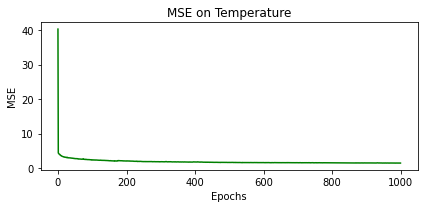

In [14]:

plt.figure(figsize=(6,3))
plt.plot(np.sqrt(m.history.history['loss']),c='green')
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.title("MSE on "+ ts)
plt.tight_layout()


Save model for further processing

In [28]:
m.save_weights("/content/drive/MyDrive/data/model_"+ts+"temp.h5")


# Predictions


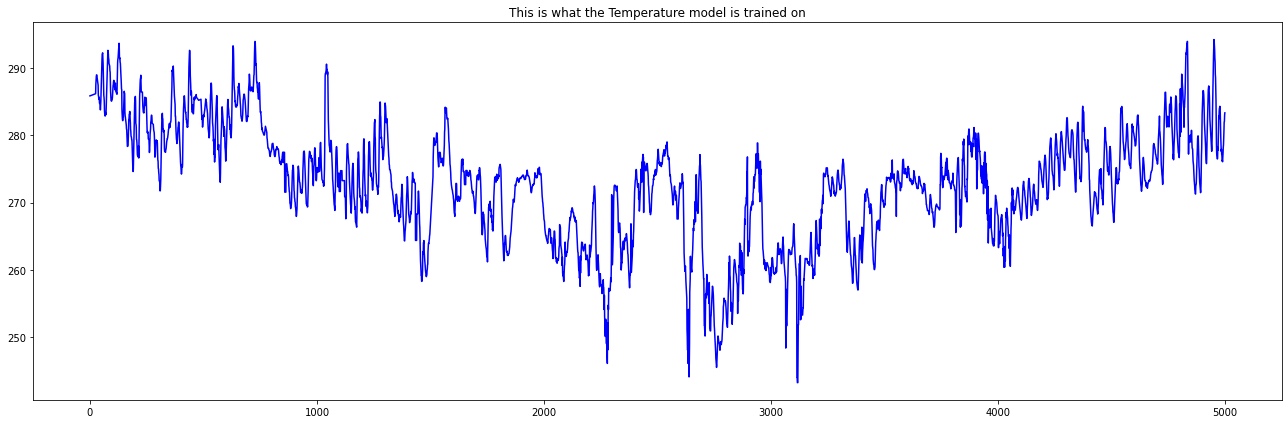

In [15]:
plt.figure(figsize=(18,6))
plt.plot(temp_trainX[:,0][:,0],c='blue')
plt.title("This is what the " + ts + " model is trained on")
plt.tight_layout()

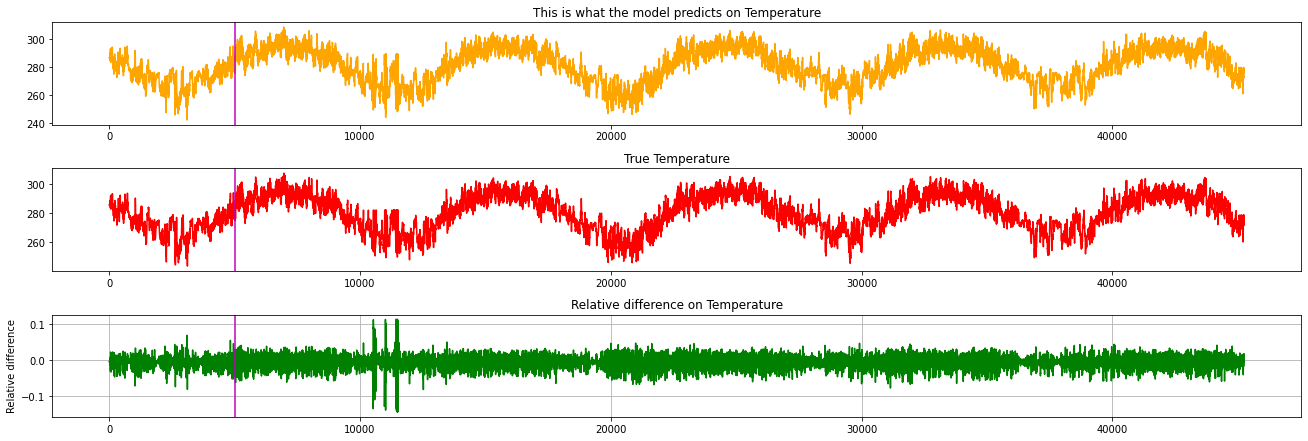

In [31]:
trainPredict = m.predict(temp_trainX)
testPredict= m.predict(temp_testX)
predicted=np.concatenate((trainPredict,testPredict),axis=0)
index = temp.index.values
x = np.array(temp[town]).reshape(-1,1)

plt.figure(figsize=(18,6))

plt.subplot(3,1,1)
plt.plot(index,predicted,c='orange')
plt.title("This is what the model predicts on "+ts)
plt.axvline(x=nb_samples, c="m")

plt.subplot(3,1,2)
plt.plot(index,x,c='r')
plt.title("True "+ts)
plt.axvline(x=nb_samples, c="m")
plt.tight_layout()

plt.subplot(3,1,3)
plt.title("Relative difference on "+ts)
plt.ylabel('Relative difference')
plt.plot(index,(x-predicted)/x,'g')
plt.axvline(x=nb_samples, c="m")
plt.grid(True)

### Distribution of prediction errors ?


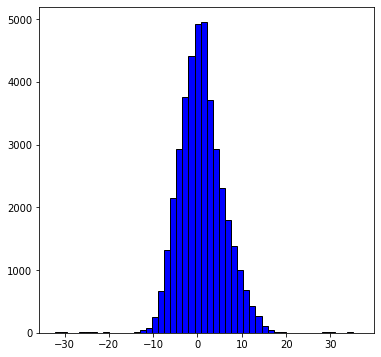

In [39]:
error=predicted[nb_samples:]-x[nb_samples:]
error=np.array(error).ravel()
plt.figure(figsize=(6,6))
plt.hist(error,bins=50,edgecolor='k',color='b')
plt.show()

## Improve the model

To make faster computations, change the model parameters

In [ ]:
num_units=128
num_dense=32

### Parameter study
- change `nb_samples`and conclude
- Make the embedding size vary and conclude
- Make the number of epochs change and conclude
- Make the batch size change and conclude